<a href="https://colab.research.google.com/github/MaithriRao/Optimization_/blob/main/SWAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import torch
import torchvision
from torchvision import datasets,transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 
import matplotlib.pyplot as plt 
import torch.optim as optim
from torch.utils.data import random_split

#Check device (cuda or CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
#transforms 

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.4914, 0.4822, 0.4465], std = [0.247, 0.243, 0.261])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.4914, 0.4822, 0.4465], std = [0.247, 0.243, 0.261])
])

#Hyperparameters
batch_size = 128
num_epochs = 150


In [4]:
#Load the dataset 
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_test)

#split trainset into train and validation 
train_ds, val_ds = random_split(trainset, [int(0.8*len(trainset)), int(00.2*len(trainset))])
print(len(train_ds))
print(len(val_ds))
print(len(testset))

#Dataloaders
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,
                                          shuffle=True, num_workers=2, pin_memory = True)
validation_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size,
                                          shuffle=True, num_workers=2, pin_memory = True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True, num_workers=2, pin_memory = True)


#image classes 
num_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
40000
10000
10000


In [5]:
#ResNet Model
class BasicBlock(nn.Module):
  expansion = 1
  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )
  
  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class BottleNeck(nn.Module):
  expansion = 4

  def __init__(self, in_planes, planes, stride=1):
    super(BottleNeck, self).__init__()
    self.conv1 = nn.Conv2d(in_planes , planes, kernel_size=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
    self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
    self.bn3 = nn.BatchNorm2d(self.expansion*planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes :
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    out = self.bn3(self.conv3(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=10):
    super(ResNet, self).__init__()
    self.in_planes = 64

    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
    self.linear = nn.Linear(512*block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes * block.expansion      
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out

#ResNet18 = ResNet(BasicBlock, [2,2,2,2])
ResNet34 = ResNet(BasicBlock, [3,4,6,3]).to(device)
#ResNet50 = ResNet(BottleNeck, [3,4,6,3])
#ResNet101 = ResNet(BottleNeck, [3,4,23,3])
#ResNet152 = ResNet(BottleNeck, [3,8,36,3])

print(ResNet34)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [6]:

import math
from torch.optim.optimizer import Optimizer

class Swats(Optimizer):
   

    def __init__(self, params, lr=1e-3, lr_decay = 1,betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=False, verbose=True, 
                 nesterov=False):
        if not 0.0 <= lr:
            raise ValueError(
                "Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError(
                "Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(
                "Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(
                "Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, lr_decay = lr_decay,betas=betas, eps=eps, phase='ADAM',
                        weight_decay=weight_decay, amsgrad=amsgrad,
                        verbose=verbose, nesterov=nesterov)

        super().__init__(params, defaults)

    def __setstate__(self, state):
        super().__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)
            group.setdefault('nesterov', False)
            group.setdefault('verbose', True)

    def step(self, closure=None):
       
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for w in group['params']:
                if w.grad is None:
                    continue
                grad = w.grad.data

                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, '
                        'please consider SparseAdam instead')

                amsgrad = group['amsgrad']

                state = self.state[w]

                # state initialization
                if len(state) == 0:
                    state['step'] = 0
                    # exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(w.data)
                    # exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(w.data)
                    # moving average for the non-orthogonal projection scaling
                    state['exp_avg2'] = w.new(1).fill_(0)
                    if amsgrad:
                        # maintains max of all exp. moving avg.
                        # of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(w.data)

                exp_avg, exp_avg2, exp_avg_sq = \
                    state['exp_avg'], state['exp_avg2'], state['exp_avg_sq'],

                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad.add_(group['weight_decay'], w.data)

                # if its SGD phase, take an SGD update and continue
                if group['phase'] == 'SGD':
                    if 'momentum_buffer' not in state:
                        buf = state['momentum_buffer'] = torch.clone(
                            grad).detach()
                    else:
                        buf = state['momentum_buffer']
                        buf.mul_(beta1).add_(grad)
                        grad = buf

                    grad.mul_(1 - beta1)
                    if group['nesterov']:
                        grad.add_(beta1, buf)

                    w.data.add_(-group['lr'] / group['lr_decay'], grad)
                    continue

                # decay the first and second moment running average coet
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    # maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * \
                    (bias_correction2 ** 0.5) / bias_correction1

                p = -step_size * (exp_avg / denom)
                w.data.add_(p)

                p_view = p.view(-1)
                pg = p_view.dot(grad.view(-1))

                if pg != 0:
                    # the non-orthognal scaling estimate
                    scaling = p_view.dot(p_view) / -pg
                    exp_avg2.mul_(beta2).add_(1 - beta2, scaling)

                    # bias corrected exponential average
                    corrected_exp_avg = exp_avg2 / bias_correction2

                    # checking criteria of switching to SGD training
                    if state['step'] > 1 and \
                            corrected_exp_avg.allclose(scaling, rtol=1e-5) and \
                            corrected_exp_avg > 0:
                        group['phase'] = 'SGD'
                        group['lr'] = corrected_exp_avg.item()
                        if group['verbose']:
                            print('Switching to SGD after '
                                  '{} steps with lr {:.5f} '
                                  'and momentum {:.5f}.'.format(
                                      state['step'], group['lr'], beta1))
        return loss


In [7]:
#loss function 
criterion = nn.CrossEntropyLoss()

#Optimizer
optimizer = Swats(ResNet34.parameters())
#optimizer = optim.Adam(ResNet34.parameters(), lr= learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

In [8]:
def model_training(model, train_loader, validation_loader, criterion, optimizer, set_device):
  best_accuracy = 0
  train_loss_history = []
  validation_loss_history = []
  training_acc_history = []
  validation_acc_history = []

  for epoch in range(0, num_epochs):
    model.train()
    train_loss_scores = []
    training_acc_scores = []
    correct_predictions = 0

    for batch_index, (images, targets) in enumerate(train_loader):
      images = images.to(set_device)
      targets = targets.to(set_device)
      
      outputs = model(images)
      loss = criterion(outputs, targets)
      train_loss_scores.append(loss.item())
      
      _, preds = torch.max(outputs, 1)
      correct_predictions = (preds==targets).sum().item()
      training_acc_scores.append(correct_predictions/targets.shape[0])

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      lr=optimizer.param_groups[0]["lr"]

      if (batch_index+1) % 100 == 0:
        print(f"Epoch : [{epoch+1}/{num_epochs}] | Step : [{batch_index+1}/{len(train_loader)}] | Loss : {loss.item()} ")
            
    train_loss_history.append((sum(train_loss_scores)/len(train_loss_scores)))
    training_acc_history.append((sum(training_acc_scores)/len(training_acc_scores))*100)      
    print(f'Epoch : {epoch+1} | Loss : {train_loss_history[-1]} | Training Accuracy : {training_acc_history[-1]}% |')

    model.eval()
    with torch.no_grad():
      correct_predictions = 0
      validation_acc_scores = []
      validation_loss_scores = []

      for images, targets in iter(validation_loader):
        images = images.to(set_device)
        targets = targets.to(set_device)
                    
        outputs = model(images)
        loss = criterion(outputs, targets)
        validation_loss_scores.append(loss.item())

        _, preds = torch.max(outputs, 1)
        correct_predictions = (preds == targets).sum().item()
        validation_acc_scores.append(correct_predictions/targets.shape[0])

      validation_loss_history.append((sum(validation_loss_scores)/len(validation_loss_scores)))
      validation_acc_history.append((sum(validation_acc_scores)/len(validation_acc_scores))*100)
      print(f'Epoch {epoch+1} | Validation Accuracy {validation_acc_history[-1]}%')

      #Early stopping
      if validation_acc_history[-1]>best_accuracy:
        best_accuracy = validation_acc_history[-1]
        print('Saving the model...')
        torch.save(model.state_dict(), f"/content/gdrive/MyDrive/swats26evening/Accuracy_{best_accuracy}_batchsize_{batch_size}.ckpt")

  return train_loss_history, validation_loss_history, training_acc_history, validation_acc_history

In [9]:
train_loss, validation_loss, train_acc, validation_acc = model_training(ResNet34, train_loader, validation_loader, criterion, optimizer, device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1055.)


Epoch : [1/150] | Step : [100/313] | Loss : 1.6998276710510254 
Epoch : [1/150] | Step : [200/313] | Loss : 1.5601651668548584 
Epoch : [1/150] | Step : [300/313] | Loss : 1.2529938220977783 
Epoch : 1 | Loss : 1.6909380416138866 | Training Accuracy : 37.93680111821086% |
Epoch 1 | Validation Accuracy 44.284018987341774%
Saving the model...
Epoch : [2/150] | Step : [100/313] | Loss : 1.286399006843567 
Epoch : [2/150] | Step : [200/313] | Loss : 1.0954937934875488 
Epoch : [2/150] | Step : [300/313] | Loss : 1.2224301099777222 
Epoch : 2 | Loss : 1.2346949655407915 | Training Accuracy : 55.655950479233226% |
Epoch 2 | Validation Accuracy 52.28441455696202%
Saving the model...
Epoch : [3/150] | Step : [100/313] | Loss : 1.0626229047775269 
Epoch : [3/150] | Step : [200/313] | Loss : 0.9477747678756714 
Epoch : [3/150] | Step : [300/313] | Loss : 0.9830998778343201 
Epoch : 3 | Loss : 0.9841030742794561 | Training Accuracy : 65.05591054313099% |
Epoch 3 | Validation Accuracy 64.131724683

In [11]:
def test_model(model, test_loader, BEST_MODEL):
   model.load_state_dict(torch.load(BEST_MODEL))

   with torch.no_grad():
     correct_predictions = []
     testing_acc_scores = []
     wrong_predictions = []
     all_targets = []
     all_preds = []

     for images, targets in iter(test_loader):
       images = images.to(device)
       targets = targets.to(device)
       outputs = model(images)
      
       _, preds = torch.max(outputs, 1)
       correct_indicies = (preds == targets).nonzero(as_tuple=True)[0]
       c_images = images[correct_indicies]
       c_targets = targets[correct_indicies]
       c_wrong_preds = preds[correct_indicies]
       testing_acc_scores.append(len(correct_indicies)/targets.shape[0])

       wrong_indicies = (preds != targets).nonzero(as_tuple=True)[0]
       w_images = images[wrong_indicies]
       w_targets = targets[wrong_indicies]
       w_wrong_preds = preds[wrong_indicies]
  
       correct_predictions += zip(c_images, c_targets, c_wrong_preds)
       wrong_predictions += zip(w_images, w_targets, w_wrong_preds)
       all_targets+= zip(targets.cpu().numpy())
       all_preds+= zip(preds.cpu().numpy())
       

     return (sum(testing_acc_scores)/len(testing_acc_scores))*100, correct_predictions, wrong_predictions, all_targets, all_preds

In [13]:
test_accuracy, correct_predictions, wrong_predictions, all_targets, all_preds = test_model(ResNet34, test_loader, BEST_MODEL='/content/gdrive/MyDrive/swats26evening/Accuracy_90.56566455696202_batchsize_128.ckpt' )

print(f'Accuracy of the network on the train dataset: {max(train_acc)}')
print(f'Accuracy of the network on the validation dataset: {max(validation_acc)}')
print(f'Accuracy of the network on the test dataset: {round(test_accuracy)}')
print(len(correct_predictions))
print(len(wrong_predictions))
print(len(all_preds))
print(len(all_targets))

Accuracy of the network on the train dataset: 99.84524760383387
Accuracy of the network on the validation dataset: 90.56566455696202
Accuracy of the network on the test dataset: 91
9072
928
10000
10000


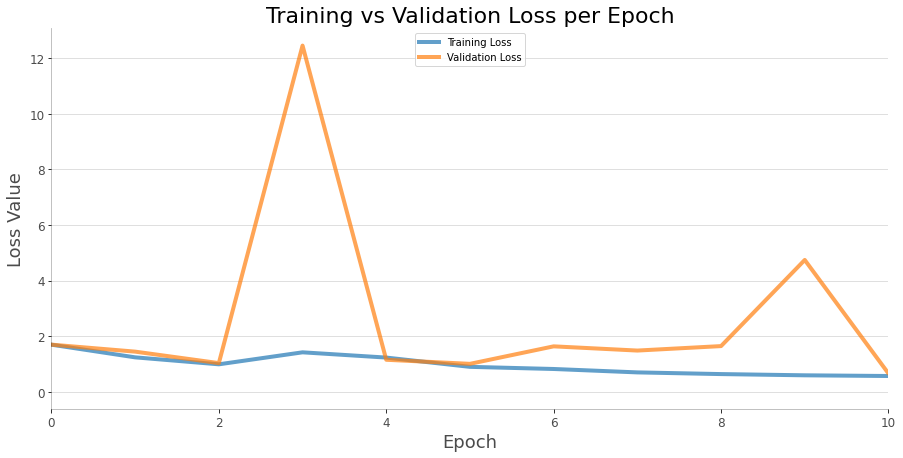

In [14]:
import pandas as pd
#Train Vs Validation loss
df = pd.DataFrame({'Training Loss':train_loss, 'Validation Loss':validation_loss})
df.plot(linewidth=4, alpha=0.7, figsize=(15,7), label='Loss')
plt.xlim([0,10])
# plt.ylim(-20,100)
plt.title('Training vs Validation Loss per Epoch', fontsize=22)
plt.grid(axis='y', alpha=.5)
plt.yticks(fontsize=12, alpha=.7)
plt.xticks(fontsize=12, alpha=.7)
plt.xlabel('Epoch', fontsize=18, alpha=.7)
plt.ylabel('Loss Value', fontsize=18, alpha=.7)
# Lighten borders
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.3)

plt.legend(loc='upper center')
plt.show()

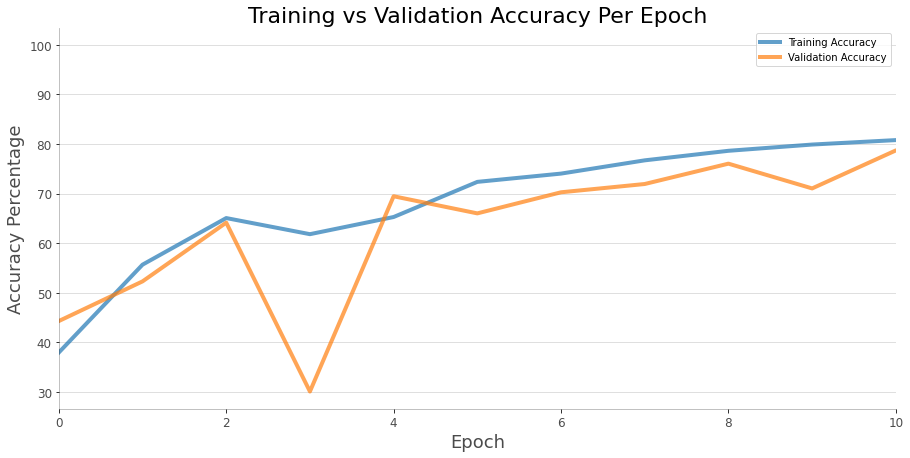

In [15]:
# Here plot epoch and accuracy over val/test set

df = pd.DataFrame({'Training Accuracy':train_acc, 'Validation Accuracy':validation_acc})
df.plot(linewidth=4, alpha=0.7, figsize=(15,7), label='Loss')
plt.xlim([0,10])
# plt.ylim(-20,100)
plt.title('Training vs Validation Accuracy Per Epoch', fontsize=22)
plt.grid(axis='y', alpha=.5)
plt.yticks(fontsize=12, alpha=.7)
plt.xticks(fontsize=12, alpha=.7)
plt.xlabel('Epoch', fontsize=18, alpha=.7)
plt.ylabel('Accuracy Percentage', fontsize=18, alpha=.7)
# Lighten borders
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.3)

plt.legend(loc='upper right')
plt.show()